In [3]:
import numpy as np
import pandas as pd
import xarray as xr

### From txt to Xarray

In [4]:
# Incertezze
# Lunghezza filo:   2 mm
# Diametro:         1 % 


g_mis_to_g_reale = lambda g: g * 4
g_to_f = lambda g: g * 9.8 / 1000

In [5]:
# Import txt
pd_data = pd.read_csv('MisureEstensimetro.txt', dtype='int,int,int,str,int,int,int', sep='\t')

# Correzione g
pd_data['d_g'] = pd_data['d_g'].apply(g_mis_to_g_reale)

# Valori aggiuntivi
pd_data['d_F'] = pd_data['d_g'].apply(g_to_f)

# Sistema Internazionale
pd_data['l'] = pd_data['l'] / 1000
pd_data['D'] = pd_data['D'] / 1000000

pd_data['d_xa'] = pd_data['d_xa'] / 100 / 1000
pd_data['d_xr'] = pd_data['d_xr'] / 100 / 1000


# Incertezze
pd_data['sigma_l'] = 0.002
pd_data['sigma_D'] = .01 * pd_data['D']
pd_data['sigma_d_x'] = 5 / 1000000
pd_data['sigma_d_F'] = g_to_f(100/3 * 4)

In [6]:
pd_data

,N,l,D,materiale,d_g,d_xa,d_xr,d_F,sigma_l,sigma_D,sigma_d_x,sigma_d_F
0,1,1.0,0.000250,tungsteno,0,0.00000,0.00000,0.00,0.002,0.000003,0.000005,1.306667
1,1,1.0,0.000250,tungsteno,400,0.00018,0.00014,3.92,0.002,0.000003,0.000005,1.306667
2,1,1.0,0.000250,tungsteno,800,0.00038,0.00034,7.84,0.002,0.000003,0.000005,1.306667
3,1,1.0,0.000250,tungsteno,1200,0.00059,0.00056,11.76,0.002,0.000003,0.000005,1.306667
4,1,1.0,0.000250,tungsteno,1600,0.00080,0.00077,15.68,0.002,0.000003,0.000005,1.306667
...,...,...,...,...,...,...,...,...,...,...,...,...
105,19,0.3,0.000279,acciaio,2400,0.00056,0.00056,23.52,0.002,0.000003,0.000005,1.306667
106,19,0.3,0.000279,acciaio,2800,0.00064,0.00065,27.44,0.002,0.000003,0.000005,1.306667
107,19,0.3,0.000279,acciaio,3200,0.00075,0.00074,31.36,0.002,0.000003,0.000005,1.306667
108,19,0.3,0.000279,acciaio,3600,0.00083,0.00084,35.28,0.002,0.000003,0.000005,1.306667


In [7]:
np_data = np.stack([
    np.split(pd_data['d_xa'].to_numpy(), 10, 0),
    np.split(pd_data['d_xr'].to_numpy(), 10, 0)
    ],
    axis = 2)
np_data.shape

(10, 11, 2)

In [8]:
def fitta_uno_prof(index):
    def fit(X,Y):
        N = X.size
        DELTA = N * (X ** 2).sum() - (X.sum()) ** 2
        a = ((X**2).sum()*(Y.sum()) - (X.sum())*(X*Y).sum()) / DELTA # q
        b = (N*(X*Y).sum() - (X.sum())*(Y.sum())) / DELTA            # m
        #
        SIGy = ((((a+b*X)-Y)**2).sum()/ (N-2)) ** .5
        SIGa = SIGy * ((X**2).sum() / DELTA) ** .5
        SIGb = SIGy * (N / DELTA) ** .5
        return [b, a], [SIGb]

    Xa = np_data[index,:,0]
    Xr = np_data[index,:,1]
    Y = np.array(pd_data.d_F.unique())

    mq_a, err_a = fit(Xa, Y)
    mq_r, err_r = fit(Xr, Y)

    mq = np.stack([mq_a, mq_r], axis=1) 
    err = np.stack([err_a, err_r], axis=1) 

    # print(mq)
    # print(err)
    return mq, err

all_fit = [fitta_uno_prof(x) for x in range(10)]

# Shape: N, deg, dir
np_fit_FX = np.stack([x[0] for x in all_fit], axis=0)

# Shape: N, dir
np_fit_FX_err = np.stack([x[1] for x in all_fit], axis=0).squeeze()

In [9]:
## Formule belle
def roba(index):
    Xa = np_data[index,:,0]
    Xr = np_data[index,:,1]
    Y = np.array(pd_data.d_F.unique())
    Yerr = np.array([1.3067 for y in Y])

    #Xa
    N = Xa.size
    DELTA = N * (Xa ** 2).sum() - (Xa.sum()) ** 2
    a = ((Xa**2).sum()*(Y.sum()) - (Xa.sum())*(Xa*Y).sum()) / DELTA # q
    b = (N*(Xa*Y).sum() - (Xa.sum())*(Y.sum())) / DELTA             # m
    #
    SIGy = ((((a+b*Xa)-Y)**2).sum()/ (N-2)) ** .5
    SIGa = SIGy * ((Xa**2).sum() / DELTA) ** .5
    SIGb = SIGy * (N / DELTA) ** .5

    #Xb
    DELTAr = N * (Xr ** 2).sum() - (Xr.sum()) ** 2
    ar = ((Xr**2).sum()*(Y.sum()) - (Xr.sum())*(Xr*Y).sum()) / DELTAr # q
    br = (N*(Xr*Y).sum() - (Xr.sum())*(Y.sum())) / DELTAr             # m
    #
    SIGyr = ((((ar+br*Xr)-Y)**2).sum()/ (N-2)) ** .5
    SIGar = SIGyr * ((Xr**2).sum() / DELTAr) ** .5
    SIGbr = SIGyr * (N / DELTAr) ** .5    
    
    return '## a b and', a, b, SIGb, '## a b rit', ar, br, SIGbr, '#### K and', 1/b, SIGb/b**2, '## K rit', 1/br, SIGbr/br**2

In [10]:
np.polyfit(np_data[0,:,0], np.array(pd_data.d_F.unique()), deg=1, full=True)

(array([1.90169912e+04, 3.92838862e-01]),
 array([0.3324509]),
 2,
 array([1.35655189, 0.39970862]),
 2.4424906541753444e-15)

In [11]:
np.polyfit(np_data[0,:,1], np.array(pd_data.d_F.unique()), deg=1, full=True)

(array([1.88204669e+04, 1.01906635e+00]),
 array([1.56609306]),
 2,
 array([1.35350889, 0.40989472]),
 2.4424906541753444e-15)

In [12]:
fitta_uno(0)

NameError: name 'fitta_uno' is not defined

In [ ]:
fitta_uno(0)

(array([[1.90169912e+04, 1.88204669e+04],
        [3.92838862e-01, 1.01906635e+00]]),
 array([[0.3324509 , 1.56609306]]))

In [ ]:
fitta_uno_prof(0)

(array([[1.90169912e+04, 1.88204669e+04],
        [3.92838862e-01, 1.01906635e+00]]),
 array([[ 88.90877143, 191.04549208]]))

In [ ]:
roba(2)

('## a b and',
 -0.09917855580336861,
 15747.889833854451,
 38.15182017439521,
 '## a b rit',
 0.1441169540022655,
 15759.551804563698,
 34.56042062404313,
 '#### K and',
 6.350057122257885e-05,
 1.5384044464465454e-07,
 '## K rit',
 6.345358119324288e-05,
 1.3915259033605868e-07)

In [13]:
def fitta_uno(index):
    Xa = np_data[index,:,0]
    Xr = np_data[index,:,1]
    Y = np.array(pd_data.d_F.unique())
    Yerr = np.array([1.3067 for y in Y])

    mq_a, err_a, _, _, _ = np.polyfit(Xa, Y, deg=1, w=1/Yerr**2, full=True)
    mq_r, err_r, _, _, _ = np.polyfit(Xr, Y, deg=1, w=1/Yerr**2, full=True)

    mq_a, err_a, _, _, _ = np.polyfit(Xa, Y, deg=1, full=True)
    mq_r, err_r, _, _, _ = np.polyfit(Xr, Y, deg=1, full=True)

    mq = np.stack([mq_a, mq_r], axis=1) 
    err = np.stack([err_a, err_r], axis=1) 

    # print(mq)
    # print(err)
    return mq, err

all_fit = [fitta_uno(x) for x in range(10)]

# Shape: N, deg, dir
np_fit_FX = np.stack([x[0] for x in all_fit], axis=0)

# Shape: N, dir
np_fit_FX_err = np.stack([x[1] for x in all_fit], axis=0).squeeze()

In [14]:
# Questo serve per fare il grafico credo
np_fit_FX.shape

(10, 2, 2)

In [15]:
mano_fit_K = 1 / np_fit_FX[:,0,:] # Sì
mano_fit_K

array([[5.25845539e-05, 5.31336447e-05],
       [5.12771779e-05, 5.13933913e-05],
       [6.35005712e-05, 6.34535812e-05],
       [5.52681836e-05, 5.53144071e-05],
       [4.19100427e-05, 4.21222303e-05],
       [3.53945343e-05, 3.52760792e-05],
       [6.74698572e-05, 6.76762364e-05],
       [6.35950223e-05, 6.38937806e-05],
       [3.28346565e-05, 3.31964880e-05],
       [2.40156669e-05, 2.38444157e-05]])

In [16]:
np_fit_FX_err

array([[0.3324509 , 1.56609306],
       [0.05497564, 0.06333253],
       [0.08928329, 0.0731575 ],
       [0.11637604, 0.11142706],
       [0.15062699, 0.2890267 ],
       [0.23514749, 0.11616456],
       [4.82244179, 4.74927501],
       [0.13398055, 0.06124048],
       [0.99136827, 0.51079301],
       [0.90681545, 0.28146146]])

In [17]:
mano_fit_K_sig = np_fit_FX_err / np_fit_FX[:,0,:] / np_fit_FX[:,0,:]
mano_fit_K_sig

array([[9.19271712e-10, 4.42136919e-09],
       [1.44550156e-10, 1.67278995e-10],
       [3.60019017e-10, 2.94558203e-10],
       [3.55479020e-10, 3.40931566e-10],
       [2.64569031e-10, 5.12814959e-10],
       [2.94586436e-10, 1.44555389e-10],
       [2.19526309e-08, 2.17520261e-08],
       [5.41861132e-10, 2.50009058e-10],
       [1.06880868e-09, 5.62897375e-10],
       [5.23007856e-10, 1.60026647e-10]])

In [18]:
nldm = pd_data[['N', 'l', 'D', 'materiale']].drop_duplicates()

In [19]:
ds = xr.Dataset(
    data_vars = dict(
        mat = ('n', nldm.materiale.to_list()),
        D = ('n', nldm.D.to_list(), dict(unit='m')),
        D_sig = ('n', (nldm.D * .01).to_list(), dict(unit='m')),
        L = ('n', nldm.l.to_list(), dict(unit='m')),
        L_sig = ('n', [.002 for x in range(10)], dict(unit='m')),
        F_sig = ('F', pd_data.sigma_d_F[:11], dict(unit='N')),
        x = (['n', 'F', 'dir'], np_data, dict(unit='m')),
        x_sig = (['n', 'F', 'dir'], np.full_like(np_data.astype(float), .000005), dict(unit='m')),
        K = (['n', 'dir'], mano_fit_K),
        K_sig = (['n', 'dir'], mano_fit_K_sig),
        x_fit = (['n', 'deg', 'dir'], np_fit_FX)
    ),
    coords = dict(
        n = ('n', nldm.N.to_list()),
        F = ('F', pd_data.d_F.unique(), dict(unit='N',)),
        dir = ('dir', ['andata', 'ritorno']),
        deg = ('deg', [1, 0])
    )
    #, attrs=dict(info='Esperienza Lab Estensimetro', data='14 marzo 2022')
)

In [20]:
# ds = xr.Dataset(
#     data_vars = dict(
#         mat = ('n', nldm.materiale.to_list()),
#         D = ('n', nldm.D.to_list(), dict(unit='m')),
#         D_sig = ('n', (nldm.D * .01).to_list(), dict(unit='m')),
#         L = ('n', nldm.l.to_list(), dict(unit='m')),
#         L_sig = ('n', [.002 for x in range(10)], dict(unit='m')),
#         F_sig = ('F', pd_data.sigma_d_F[:11], dict(unit='N')),
#         x = (['n', 'F', 'dir'], np_data, dict(unit='m')),
#         x_sig = (['n', 'F', 'dir'], np.full_like(np_data.astype(float), .000005), dict(unit='m')),
#     ),
#     coords = dict(
#         n = ('n', nldm.N.to_list()),
#         F = ('F', pd_data.d_F.unique(), dict(unit='N',)),
#         dir = ('dir', ['andata', 'ritorno'])
#     ),
#     attrs=dict(
#         info='Esperienza Lab Estensimetro',
#         data='14 marzo 2022'
#     )
# )

In [21]:
# nldm = pd_data[['N', 'l', 'D', 'materiale']].drop_duplicates()

# ds = xr.Dataset(
#     data_vars = dict(
#         materiale = ('n', nldm.materiale.to_list()),
#         diametro = ('n', nldm.D.to_list(), dict(unit='μm', incertezza='1%')),
#         lunghezza = ('n', nldm.l.to_list(), dict(unit='mm', incertezza='2 mm')),
#         sigma_F = ('F', pd_data.sigma_d_F[:11], dict(unit='N')),
#         delta_x = (['n', 'F', 'dir'], np_data, dict(unit='1/100 mm')),
#         delta_x_m = (['n', 'F', 'dir'], np_data * 10 ** (-2-3), dict(unit='m')),
#         sigma_x = (['n', 'F', 'dir'], np.full_like(np_data.astype(float), .5), dict(unit='1/100 mm')),
#         sigma_x_m = (['n', 'F', 'dir'], np.full_like(np_data.astype(float), .5) * 10 ** (-2-3), dict(unit='m'))
#     ),
#     coords = dict(
#         n = ('n', nldm.N.to_list()),
#         F = ('F', pd_data.d_F.unique(), dict(unit='N',)),
#         dir = ('dir', ['andata', 'ritorno'])
#     ),
#     attrs=dict(
#         info='Esperienza Lab Estensimetro',
#         data='14 marzo 2022'
#     )
# )

# da = ds.delta_x

In [22]:
ds

<xarray.Dataset>
Dimensions:  (n: 10, F: 11, dir: 2, deg: 2)
Coordinates:
  * n        (n) int64 1 3 6 7 9 10 13 14 18 19
  * F        (F) float64 0.0 3.92 7.84 11.76 15.68 ... 27.44 31.36 35.28 39.2
  * dir      (dir) <U7 'andata' 'ritorno'
  * deg      (deg) int64 1 0
Data variables:
    mat      (n) <U9 'tungsteno' 'ottone' 'acciaio' ... 'acciaio' 'acciaio'
    D        (n) float64 0.00025 0.0005 0.000305 ... 0.000279 0.000279 0.000279
    D_sig    (n) float64 2.5e-06 5e-06 3.05e-06 ... 2.79e-06 2.79e-06 2.79e-06
    L        (n) float64 1.0 1.0 0.95 0.95 0.95 0.95 0.9 0.8 0.4 0.3
    L_sig    (n) float64 0.002 0.002 0.002 0.002 ... 0.002 0.002 0.002 0.002
    F_sig    (F) float64 1.307 1.307 1.307 1.307 ... 1.307 1.307 1.307 1.307
    x        (n, F, dir) float64 0.0 0.0 0.00018 ... 0.00084 0.00094 0.00094
    x_sig    (n, F, dir) float64 5e-06 5e-06 5e-06 5e-06 ... 5e-06 5e-06 5e-06
    K        (n, dir) float64 5.258e-05 5.313e-05 ... 2.402e-05 2.384e-05
    K_sig    (n, dir) float64 9.193e-10 4.421e-09 1.446e-10 ... 5.23e-10 1.6e-10
    x_fit    (n, deg, dir) float64 1.902e+04 1.882e+04 0.3928 ... 0.3701 0.07952

### Export NetCDF

In [ ]:
ds.to_netcdf('MisureEstensimetro.nc')

### Graphs

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker

import seaborn as sns

import functools as fct

In [24]:
style = ['white', 'dark', 'whitegrid', 'darkgrid', 'ticks'][2]
sns.set_style(style)

In [25]:
palette = sns.husl_palette(18)
print(' ', [' '+str(x) for x in range(6)],' ', [' '+str(x+6) for x in range(6)], ['_'+str(x+12) for x in range(6)])
palette

  [' 0', ' 1', ' 2', ' 3', ' 4', ' 5']   [' 6', ' 7', ' 8', ' 9', ' 10', ' 11'] ['_12', '_13', '_14', '_15', '_16', '_17']


[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9707505829046977, 0.4626541987597626, 0.26486329418330007),
 (0.8369430560927636, 0.5495828952802333, 0.1952683223448124),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.6430915736746491, 0.6271955086583126, 0.19381135329796756),
 (0.5310702086647983, 0.6569113639885688, 0.1931838276161326),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.1998437102815942, 0.6927711055021983, 0.4485948481767363),
 (0.20582072623426667, 0.6842209016721069, 0.5675558225732941),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.2151139535594307, 0.6700707833028816, 0.7112365203426209),
 (0.22126158707091403, 0.6600977737826563, 0.7915486637100363),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.5392573577708815, 0.5821140171749066, 0.9584212824085171),
 (0.731751635642941, 0.5128186367840487, 0.9581005178234921),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225),
 (0.9614880299080136, 0.3909885385134758, 0.8298287106954371),
 (0.9648889414626248, 0.41896694790705413, 0.692031255809005)]

In [26]:
# common
graph_default_size = (7,4.5)
graph_default_dpi = 200

graph_base_name = '../grafici/graph_'

In [306]:
sns.husl_palette(10)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8616090647292522, 0.536495730113334, 0.19548899031476086),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.46810256823426105, 0.6699492535792404, 0.1928958739904499),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 (0.433280341176423, 0.6065273407962815, 0.9585467098271748),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 (0.962272393509669, 0.3976451968965351, 0.8008274363432775)]

#### 5

In [369]:
# Grafico ∆F/∆x

def plot5(ds_est, save=True):
    sns.set_style('whitegrid')
    palette18 = sns.husl_palette(18)
    clrs = iter([palette18[x] for x in [12,0,10,1] ])
    clrs = iter([palette18[x] for x in [12,14,10,15] ])

    plot_id = graph_base_name + '5_dFdX'

    # Info
    est_n = str(ds_est.n.item())
    est_mat = ds_est.mat.item().capitalize()
    est_D = str(ds_est.D.item() * 1000)
    est_l = str(int(ds_est.L.item() * 1000))

    # Data
    ds_est_a = ds_est.sel(dir='andata')
    ds_est_r = ds_est.sel(dir='ritorno')
    
    # Fit
    dF = [ds_est.F.min().item(), ds_est.F.max().item()]
    # Andata
    m, q = ds_est.x_fit.sel(dir='andata').to_numpy()
    dXa = [x*m + q for x in dF]
    # Ritorno
    m, q = ds_est.x_fit.sel(dir='ritorno').to_numpy()
    dXr = [x*m + q for x in dF]

    # Fit Andata
    dXa = ds_est.sel(dir='andata').x
    m, q = ds_est.sel(dir='andata').x_fit
    dFa = [m*x+q for x in dXa]
    # Fit Ritorno
    dXr = ds_est.sel(dir='ritorno').x
    m, q = ds_est.sel(dir='ritorno').x_fit
    dFr = [m*x+q for x in dXr]

    # Plot
    # plt.figure(figsize=graph_default_size)
    plt.figure(figsize=(6,4))
    
    plt.plot(dXa, dFa, '-', label='Fit allungamento', color=next(clrs))
    plt.plot(dXr, dFr, '--', label='Fit accorciamento', color=next(clrs))

    plt.errorbar(x=ds_est_a.x, y=ds_est_a.F, xerr=ds_est_a.x_sig, yerr=ds_est_a.F_sig, fmt='o', capsize=3, label='Allungamento', color=next(clrs))
    plt.errorbar(x=ds_est_r.x, y=ds_est_r.F, xerr=ds_est_r.x_sig, yerr=ds_est_r.F_sig, fmt='^', capsize=3, label='Accorciamento', color=next(clrs))

    # Labels
    plt.ylabel('∆F [N]')
    plt.xlabel('∆x [$10^{-2}$ mm]')
    # Ticks
    plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x*100000), ',')))
    # Legend
    order = [2,0,3,1]
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend([handles[i] for i in order],[labels[i] for i in order], loc='lower right', ncol=1)
    # Info text
    plt.text(0.06, 0.94-.05, '[' + str(ds_est.n.item()) + '] ' + est_mat, horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
    plt.text(0.06, 0.88-.05, 'D = ' + est_D + ' mm', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
    plt.text(0.06, 0.82-.05, 'L = ' + est_l + ' mm', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)

    # Save
    if save:
        plt.savefig(plot_id + '_N' + est_n + '_' + est_mat[:3], dpi=graph_default_dpi)

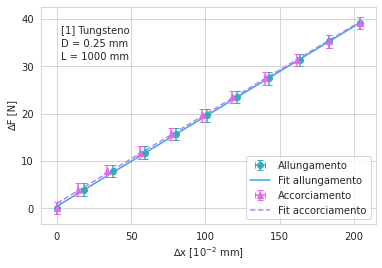

In [370]:
plot5(ds.sel(n=1))

In [118]:
import functools as fct
fct.reduce(lambda a,b: a+'-'+b, ['1', '2', '3'])

'1-2-3'

In [34]:
palette24 = sns.husl_palette(24)
palette24

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9699521567340649, 0.4569882390259858, 0.36385324448493633),
 (0.903599057664843, 0.511987276335809, 0.19588350060161624),
 (0.8087954113106306, 0.5634700050056693, 0.19502642696727285),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.6666319352625271, 0.6197366714155128, 0.19396267878823373),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.49382662140640926, 0.6649121332643736, 0.19300804648700284),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.19783576093349015, 0.6955516966063037, 0.3995301037444499),
 (0.20312757197899856, 0.6881249249803418, 0.5177618167447304),
 (0.20703735729643508, 0.6824290013722435, 0.5885318893529169),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.21387918628643265, 0.6720135434784761, 0.693961140878689),
 (0.21786710662428366, 0.6656671601322255, 0.7482809385065813),
 (0.22335772267769388, 0.6565792317435265, 0.8171355503265633),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.4768773964929644, 0.5974418160509446, 0.9584992622400258),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.774710828527837, 0.49133823414365724, 0.9580114121137316),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225),
 (0.9603888539940703, 0.3814317878772117, 0.8683117650835491),
 (0.9633321742064956, 0.40643825645731757, 0.7592537599568671),
 (0.9656056642634557, 0.4245907603266889, 0.6579786740552919)]

In [462]:
def plot5_multi(ds_est, text_extra=None, text_extraa=None, vshrink=False):
    sns.set_style('whitegrid')
    issingle=False
    dsnvalues = ds_est.n.values.tolist()
    if type(dsnvalues) != list:
        issingle=True
        dsnvalues = [dsnvalues]
    
    palette24 = sns.husl_palette(24)
    iter16colors = iter([palette24[x:x+4] for x in [0, 6, 13, 18] ])
    if issingle:
        iter16colors = iter([[palette24[x] for x in [13,0,14,1]]])

    ds_len = len(dsnvalues) * 2
    mezzo_order = list(range(0, ds_len))
    order = [x+ds_len for x in mezzo_order] + mezzo_order

    # order3 = [6,7,8,9,10,11, 0,1,2,3,4,5]
    # order4 = [8,9,10,11,12,13,14,15, 0,1,2,3,4,5,6,7]
    # order = order3 if len(dsnvalues) == 3 else order4

    text_shift = 0 if len(dsnvalues) == 3 else 5.6 if len(dsnvalues) == 4 else -5.6
    text_shift_px = 0 if len(dsnvalues) == 3 else 30 if len(dsnvalues) == 4 else -30

    plot_spec_id = fct.reduce(lambda a,b: a+'-'+b, [str(x) for x in dsnvalues])

    def plot_one(da_est):
        clrs = iter(next(iter16colors))

        # Data
        est_n = ' ' + str(da_est.n.item())
        ds_est_a = da_est.sel(dir='andata')
        ds_est_r = da_est.sel(dir='ritorno')

        # Fit
        dF = [da_est.F.min().item(), da_est.F.max().item()]
        # Andata
        m, q = da_est.x_fit.sel(dir='andata').to_numpy()
        dXa = [x*m + q for x in dF]
        # Ritorno
        m, q = da_est.x_fit.sel(dir='ritorno').to_numpy()
        dXr = [x*m + q for x in dF]

        # Fit Andata
        dXa = da_est.sel(dir='andata').x
        m, q = da_est.sel(dir='andata').x_fit
        dFa = [m*x+q for x in dXa]
        # Fit Ritorno
        dXr = da_est.sel(dir='ritorno').x
        m, q = da_est.sel(dir='ritorno').x_fit
        dFr = [m*x+q for x in dXr]

        # Plot
        plt.plot(dXa, dFa, '-', label='Fit All.'+est_n, color=next(clrs))
        plt.plot(dXr, dFr, '--', label='Fit Acc.'+est_n, color=next(clrs))

        plt.errorbar(x=ds_est_a.x, y=ds_est_a.F, xerr=ds_est_a.x_sig, yerr=ds_est_a.F_sig, fmt='o', capsize=3, label='All.'+est_n, color=next(clrs))
        plt.errorbar(x=ds_est_r.x, y=ds_est_r.F, xerr=ds_est_r.x_sig, yerr=ds_est_r.F_sig, fmt='^', capsize=3, label='Acc.'+est_n, color=next(clrs))


    # Common
    plot_id = graph_base_name + '5_dFdX_uniti_' + plot_spec_id
    # plt.figure(figsize=graph_default_size)
    plt.figure(figsize=(8,4.5) if vshrink else (8,6))


    if(len(dsnvalues) > 1):
        for n in dsnvalues:
            plot_one(ds_est.sel(n=n))
    else:
        plot_one(ds_est)

    # LIM
    maxx = ds_est.x.max().item()
    maxx_lim = maxx + .00035
    plt.xlim(-.0003, maxx_lim)
    plt.ylim(-5, 45)


    # Labels
    plt.ylabel('∆F [N]')
    plt.xlabel('∆x [$10^{-2}$ mm]')
    # Ticks
    plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x*100000), ',')))

    # Legend
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend([handles[i] for i in order],[labels[i] for i in order], loc='lower right', ncol=2)

    # Text extra
    if text_extra != None:
        plt.text(maxx_lim-.00005, text_shift+12.4, text_extra, horizontalalignment='right', verticalalignment='center')
        # plt.text(480,text_shift_px+155, text_extra, horizontalalignment='right', verticalalignment='center', transform=None)
    if text_extraa != None:
        plt.text(maxx_lim-.00005, text_shift+15.4, text_extraa, horizontalalignment='right', verticalalignment='center')
        # plt.text(480,text_shift_px+170, text_extraa, horizontalalignment='right', verticalalignment='center', transform=None)

    plt.savefig(plot_id, dpi=graph_default_dpi)


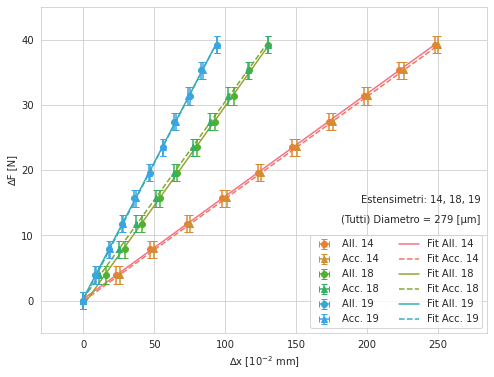

In [458]:
plot5_multi(ds.where(ds.D == 0.000279, drop=True).where(ds.n != 13, drop=True), '(Tutti) Diametro = 279 [μm]', 'Estensimetri: 14, 18, 19')

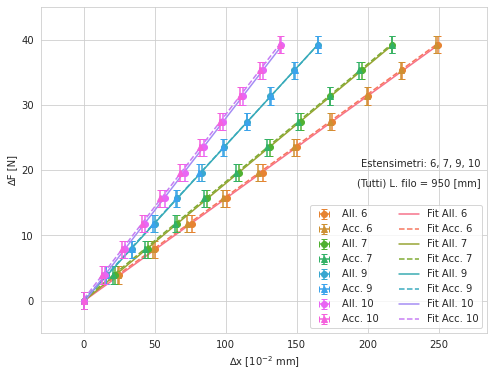

In [443]:
plot5_multi(ds.where(ds.L == 0.95, drop=True), '(Tutti) L. filo = 950 [mm]', 'Estensimetri: 6, 7, 9, 10')

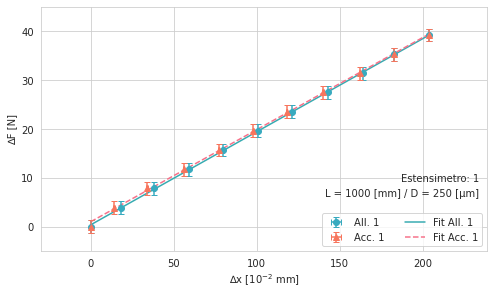

In [463]:
plot5_multi(ds.sel(n=1), 'L = 1000 [mm] / D = 250 [μm]', 'Estensimetro: 1', True)

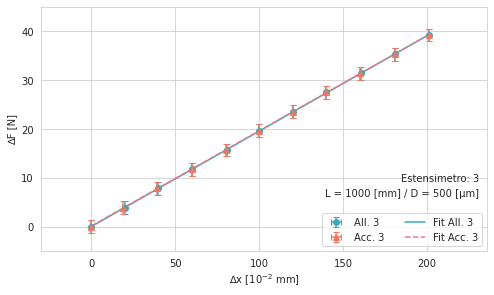

In [464]:
plot5_multi(ds.sel(n=3), 'L = 1000 [mm] / D = 500 [μm]', 'Estensimetro: 3', True)

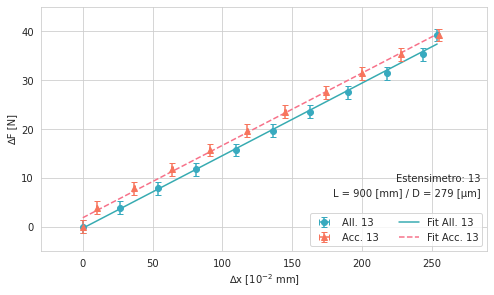

In [465]:
plot5_multi(ds.sel(n=13), 'L = 900 [mm] / D = 279 [μm]', 'Estensimetro: 13', True)

In [371]:
def all5(ds_all):
    for n in ds_all.n:
        plot5(ds_all.sel(n=n))

In [409]:
ds.n.values.tolist()

[1, 3, 6, 7, 9, 10, 13, 14, 18, 19]

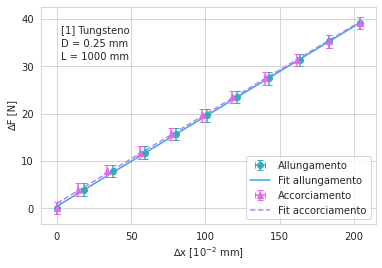

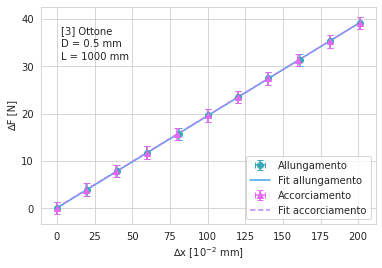

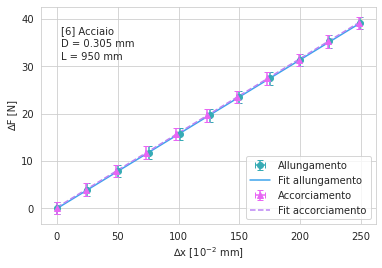

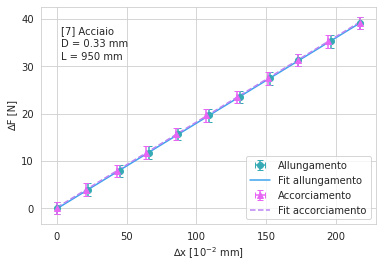

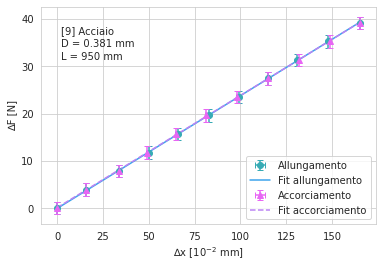

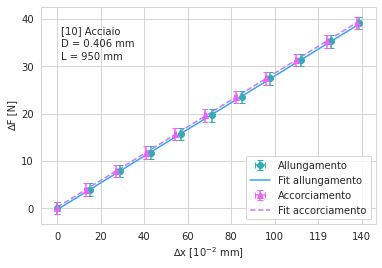

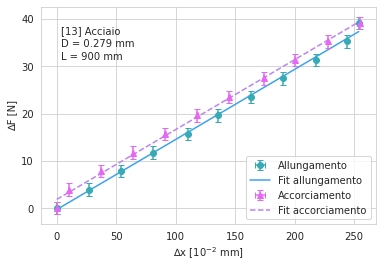

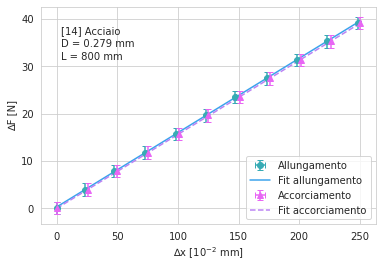

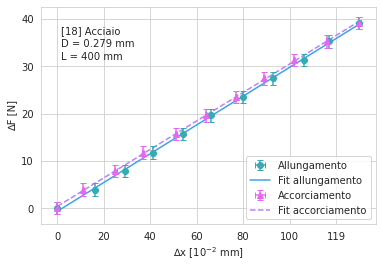

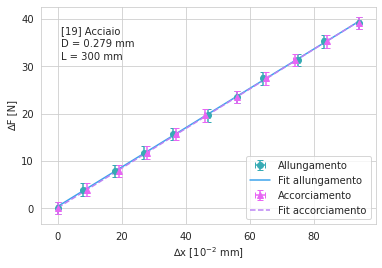

In [372]:
all5(ds)

#### 6.1.

In [22]:
# temp_Ki = ds.x.where(ds.F != 0, drop=True) / ds.F.where(ds.F != 0, drop=True)
# temp_Ki_mean = temp_Ki.mean(dim='F')
# temp_Ki_sigma = ((temp_Ki - temp_Ki_mean) ** 2).mean(dim='F') ** .5
# temp_Ki_mean_sigma = temp_Ki_sigma / (10 ** .5)

In [23]:
# DA CONTROLLARE QUESTO
# ds.K.to_dataset(name='K_sig') * .01
# ds = ds.merge(ds.K.to_dataset(name='K_sig') * .01)

# ds = ds.merge(temp_Ki_mean_sigma.to_dataset(name='K_sig'))

In [24]:
ds

<xarray.Dataset>
Dimensions:  (n: 10, F: 11, dir: 2, deg: 2)
Coordinates:
  * n        (n) int64 1 3 6 7 9 10 13 14 18 19
  * F        (F) float64 0.0 3.92 7.84 11.76 15.68 ... 27.44 31.36 35.28 39.2
  * dir      (dir) <U7 'andata' 'ritorno'
  * deg      (deg) int64 1 0
Data variables:
    mat      (n) <U9 'tungsteno' 'ottone' 'acciaio' ... 'acciaio' 'acciaio'
    D        (n) float64 0.00025 0.0005 0.000305 ... 0.000279 0.000279 0.000279
    D_sig    (n) float64 2.5e-06 5e-06 3.05e-06 ... 2.79e-06 2.79e-06 2.79e-06
    L        (n) float64 1.0 1.0 0.95 0.95 0.95 0.95 0.9 0.8 0.4 0.3
    L_sig    (n) float64 0.002 0.002 0.002 0.002 ... 0.002 0.002 0.002 0.002
    F_sig    (F) float64 1.307 1.307 1.307 1.307 ... 1.307 1.307 1.307 1.307
    x        (n, F, dir) float64 0.0 0.0 0.00018 ... 0.00084 0.00094 0.00094
    x_sig    (n, F, dir) float64 5e-06 5e-06 5e-06 5e-06 ... 5e-06 5e-06 5e-06
    K        (n, dir) float64 5.258e-05 5.313e-05 ... 2.402e-05 2.384e-05
    K_sig    (n, dir) float64 5.384e-10 2.589e-09 ... 3.063e-10 9.372e-11
    x_fit    (n, deg, dir) float64 1.902e+04 1.882e+04 0.3928 ... 0.3701 0.07952

#### 6.

In [27]:
# (4 * ds.L / (3.14 * (ds.D ** 2) * ds.K)).to_dataset(name='E')
ds = ds.merge((4 * ds.L / (3.14 * (ds.D ** 2) * ds.K)).to_dataset(name='E'))

In [28]:
# (ds.E * ((ds.L_sig/ds.L)**2 + (ds.K_sig/ds.K)**2 + 4*(ds.D_sig/ds.D)**2) ** .5).to_dataset(name='E_sig')
ds = ds.merge((ds.E * ((ds.L_sig/ds.L)**2 + (ds.K_sig/ds.K)**2 + 4*(ds.D_sig/ds.D)**2) ** .5).to_dataset(name='E_sig'))

#### 7.

In [29]:
sum_7a = (ds.E / ds.E_sig ** 2).sum(dim='dir')
sum_7b = (1 / ds.E_sig ** 2).sum(dim='dir')

ds7 = (sum_7a / sum_7b).to_dataset(name='mE')
ds7s = ((1 / sum_7b) ** .5).to_dataset(name='mE_sig')

ds = ds.merge(ds7).merge(ds7s)

#### 8.

In [30]:
sum_8a = (ds.K / ds.K_sig ** 2).sum(dim='dir')
sum_8b = (1 / ds.K_sig ** 2).sum(dim='dir')

ds8 = (sum_8a / sum_8b).to_dataset(name='mK')
ds8s = ((1 / sum_8b) ** .5).to_dataset(name='mK_sig')

ds = ds.merge(ds8).merge(ds8s)

#### 9.

In [31]:
ds = ds.merge((4 * ds.L / (3.14 * (ds.D ** 2) * ds.mK)).to_dataset(name='Ep'))

In [32]:
ds = ds.merge((ds.Ep * ((ds.L_sig/ds.L)**2 + (ds.mK_sig/ds.mK)**2 + 4*(ds.D_sig/ds.D)**2) ** .5).to_dataset(name='Ep_sig'))

#### 10.

Ok

#### 11.

In [509]:
palette24

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9699521567340649, 0.4569882390259858, 0.36385324448493633),
 (0.903599057664843, 0.511987276335809, 0.19588350060161624),
 (0.8087954113106306, 0.5634700050056693, 0.19502642696727285),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.6666319352625271, 0.6197366714155128, 0.19396267878823373),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.49382662140640926, 0.6649121332643736, 0.19300804648700284),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.19783576093349015, 0.6955516966063037, 0.3995301037444499),
 (0.20312757197899856, 0.6881249249803418, 0.5177618167447304),
 (0.20703735729643508, 0.6824290013722435, 0.5885318893529169),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.21387918628643265, 0.6720135434784761, 0.693961140878689),
 (0.21786710662428366, 0.6656671601322255, 0.7482809385065813),
 (0.22335772267769388, 0.6565792317435265, 0.8171355503265633),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.4768773964929644, 0.5974418160509446, 0.9584992622400258),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.774710828527837, 0.49133823414365724, 0.9580114121137316),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225),
 (0.9603888539940703, 0.3814317878772117, 0.8683117650835491),
 (0.9633321742064956, 0.40643825645731757, 0.7592537599568671),
 (0.9656056642634557, 0.4245907603266889, 0.6579786740552919)]

In [645]:
# Grafico <K> / S^-1

def plot11_1(ds_est, name=''):
    sns.set_style('whitegrid')
    plot_id = graph_base_name + '11_1_KS'

    # Data
    X = 4 / (3.14 * ds_est.D ** 2)
    Y = ds_est.mK

    Xerr = ds_est.D_sig * 2
    Yerr = ds_est.mK_sig

    m, q = np.polyfit(X,Y,deg=1)

    # Plot
    # plt.figure(figsize=graph_default_size)
    plt.figure(figsize=(4,3))

    plt.errorbar(x=X, y=Y, xerr=Xerr, yerr=Yerr, fmt='o', capsize=3, label='$K(1/S)$', color=palette24[16])

    plt.plot([X.min()*.98, X.max()*1.02], [m*x+q for x in [X.min()*.98, X.max()*1.02]], '-', label='Fit', color=palette24[18])    

    # Labels
    plt.grid(visible=True, linestyle=':')
    plt.ylabel('K [$10^{-6}$ m/N]')
    plt.xlabel('1/S [$10^{6} m^{-2}$]')

    # Ticks
    plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000000), ',')))
    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x*1000000), ',')))
    
    # Legend
    order = [1,0]
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend([handles[i] for i in order],[labels[i] for i in order], loc='lower right', ncol=1)
    
    plt.tight_layout()
    

    # Save
    plt.savefig(plot_id, dpi=graph_default_dpi)

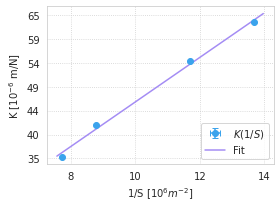

In [646]:
plot11_1(ds.where(ds.L == 0.950, drop=True))

In [647]:
# Grafico <K> / x0

def plot11_2(ds_est, name=''):
    sns.set_style('whitegrid')
    plot_id = graph_base_name + '11_2_Kx0'

    # Data
    X = ds_est.L
    Y = ds_est.mK

    Xerr = ds_est.L_sig
    Yerr = ds_est.mK_sig

    m, q = np.polyfit(X,Y,deg=1)

    # Plot
    # plt.figure(figsize=graph_default_size)
    plt.figure(figsize=(4,3))

    plt.errorbar(x=X, y=Y, xerr=Xerr, yerr=Yerr, fmt='o', capsize=3, label='K($x_0$)', color=palette24[16])

    plt.plot([X.min()*.98, X.max()*1.02], [m*x+q for x in [X.min()*.98, X.max()*1.02]], '-', label='Fit', color=palette24[18])    

    # Labels
    plt.grid(visible=True, linestyle=':')
    plt.ylabel('K [$10^{-6}$ m/N]')
    plt.xlabel('$x_0$ [m]')

    # Ticks
    # plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x*100000), ',')))
    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x*1000000), ',')))

    # Legend
    order = [1,0]
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend([handles[i] for i in order],[labels[i] for i in order], loc='lower right', ncol=1)
    
    plt.tight_layout()

    # Save
    plt.savefig(plot_id, dpi=graph_default_dpi)

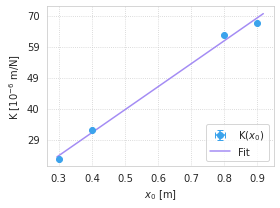

In [648]:
plot11_2(ds.where(ds.D == .000279, drop=True))

#### 12.

In [35]:
# Grafico <K> / x0

def plot12(ds_est, name=''):
    sns.set_style('whitegrid')
    plot_id = graph_base_name + '12_RKx'

    # Data
    X = ds_est.L
    Y = ds_est.mK / ds_est.L

    Yerr = Y * ((ds_est.L_sig/ds_est.L)**2 + (ds_est.mK_sig/ds_est.mK)**2) ** .5

    m, q = np.polyfit(X,Y,deg=1)

    # Plot
    # plt.figure(figsize=graph_default_size)
    plt.figure(figsize=(8,3))

    plt.errorbar(x=X, y=Y, yerr=Yerr, fmt='o', capsize=3, label='Rapporto', color=palette24[7])

    plt.plot([X.min()*.98, X.max()*1.02], [m*x+q for x in [X.min()*.98, X.max()*1.02]], '-', label='Fit', color=palette24[9])    

    # Labels
    plt.ylabel('$\\langle$K$\\rangle$/$x_0$ [$10^{-6} N^{-1}$]')
    plt.xlabel('x0 [m]')

    # Ticks
    # plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x*100000), ',')))
    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x*1000000), ',')))

    # Legend
    order = [1,0]
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend([handles[i] for i in order],[labels[i] for i in order], loc='lower center', ncol=1)
    
    plt.tight_layout()

    # Save
    plt.savefig(plot_id, dpi=graph_default_dpi)

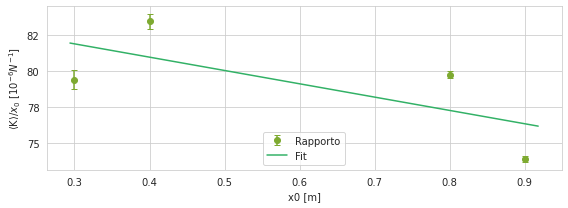

In [36]:
plot12(ds.where(ds.D == 0.000279, drop=True).where(ds.mat == 'acciaio', drop=True))#.where(ds.n != 13, drop=True))

#### 13.

In [37]:
# Grafico K*D^2 / D^2

def plot13(ds_est, name=''):
    sns.set_style('whitegrid')
    plot_id = graph_base_name + '13_PKD'

    # Data
    X = ds_est.D ** 2
    Y = ds_est.mK * X

    Yerr = Y * (4*(ds_est.D_sig/ds_est.D)**2 + (ds_est.mK_sig/ds_est.mK)**2) ** .5

    m, q = np.polyfit(X,Y,deg=1)

    # Plot
    # plt.figure(figsize=graph_default_size)
    plt.figure(figsize=(8,3))

    plt.errorbar(x=X, y=Y, yerr=Yerr, fmt='o', capsize=3, label='Prodotto', color=palette24[7])

    plt.plot([X.min()*.98, X.max()*1.02], [m*x+q for x in [X.min()*.98, X.max()*1.02]], '-', label='Fit', color=palette24[9])    

    # Labels
    plt.ylabel('$P=<K>D^2$ [$10^{-1} m^3/N$]')
    plt.xlabel('$D^2$ [$mm^2$]')
    # Ticks
    plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x*10**8)*.01, ',')))
    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x*10**(3*3)*100000)/100, ',')))
    # Legend
    order = [1,0]
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend([handles[i] for i in order],[labels[i] for i in order], loc='lower center', ncol=1)
    
    plt.tight_layout()

    # Save
    plt.savefig(plot_id, dpi=graph_default_dpi)

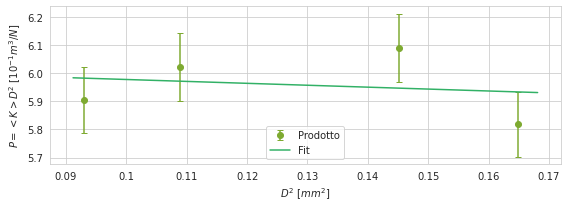

In [38]:
plot13(ds.where(ds.L == 0.95, drop=True).where(ds.mat == 'acciaio', drop=True))

#### Confronti E, \<E\>

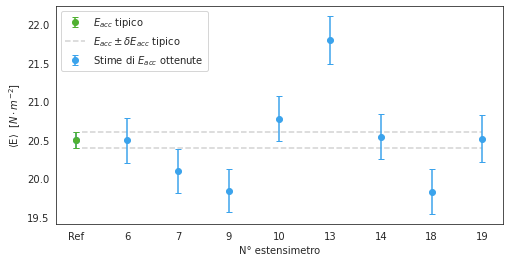

In [566]:
def plot_confr1():
    sns.set_style('white')
    plot_id = graph_base_name + '00_confr_acc_E'
    # plt.figure(figsize=graph_default_size)
    plt.figure(figsize=(8,4))

    acc_E = 20.5 * 10 ** 10
    acc_E_sig = .1 * 10 ** 10

    acc_E_max = acc_E + acc_E_sig
    acc_E_min = acc_E - acc_E_sig

    acc_ds = ds.where(ds.mat == 'acciaio', drop=True)

    Y = [acc_E] + list(acc_ds.mE.to_numpy())
    Yerr = [acc_E_sig] + list(acc_ds.mE_sig.to_numpy())
    Yn = list(acc_ds.n.to_numpy())

    X = list(range(len(Y)))
    Xlab = ['Ref'] + [str(x) for x in Yn]

    plt.plot([0.1, X[-1]], [acc_E_max, acc_E_max], '--', color='lightgrey', label='$E_{acc} \pm \delta E_{acc}$ tipico')
    plt.plot([0.1, X[-1]], [acc_E_min, acc_E_min], '--', color='lightgrey')

    plt.errorbar(X, Y, Yerr, fmt='o', capsize=3, label='Stime di $E_{acc}$ ottenute', color=palette24[16])
    plt.errorbar(X[0], Y[0], Yerr[0], fmt='o', capsize=3, label='$E_{acc}$ tipico', color=palette24[8])

    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(x/10**10, ',')))

    plt.xticks(X, Xlab)

    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2,0,1]
    plt.legend([handles[i] for i in order],[labels[i] for i in order], loc='upper left')

    plt.xlabel('N° estensimetro')
    plt.ylabel('$\\langle$E$\\rangle$  $[N \cdot m^{-2}]$')
    
    # Save
    plt.savefig(plot_id, dpi=graph_default_dpi)

plot_confr1()

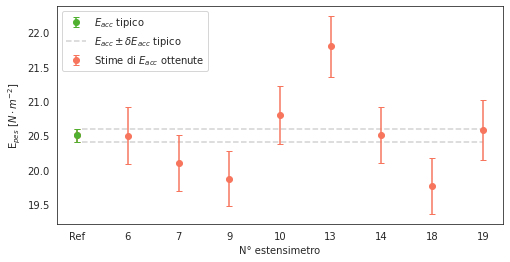

In [578]:
def plot_confr2():
    sns.set_style('white')
    plot_id = graph_base_name + '00_confr_acc_Epes'
    # plt.figure(figsize=graph_default_size)
    plt.figure(figsize=(8,4))
    
    acc_E = 20.5 * 10 ** 10
    acc_E_sig = .1 * 10 ** 10
    
    acc_E_max = acc_E + acc_E_sig
    acc_E_min = acc_E - acc_E_sig
    
    acc_ds = ds.where(ds.mat == 'acciaio', drop=True)
    
    Y = [acc_E] + list(acc_ds.Ep.to_numpy())
    Yerr = [acc_E_sig] + list(acc_ds.Ep_sig.to_numpy())
    Yn = list(acc_ds.n.to_numpy())
    
    X = list(range(len(Y)))
    Xlab = ['Ref'] + [str(x) for x in Yn]
    
    plt.plot([0.1, X[-1]], [acc_E_max, acc_E_max], '--', color='lightgrey', label='$E_{acc} \pm \delta E_{acc}$ tipico')
    plt.plot([0.1, X[-1]], [acc_E_min, acc_E_min], '--', color='lightgrey')
    
    plt.errorbar(X, Y, Yerr, fmt='o', capsize=3, label='Stime di $E_{acc}$ ottenute', color=palette24[1])
    plt.errorbar(X[0], Y[0], Yerr[0], fmt='o', capsize=3, label='$E_{acc}$ tipico', color=palette24[8])
    
    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(x/10**10, ',')))
    
    plt.xticks(X, Xlab)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2,0,1]
    plt.legend([handles[i] for i in order],[labels[i] for i in order], loc='upper left')
    
    plt.xlabel('N° estensimetro')
    plt.ylabel('E$_{pes}$ $[N \cdot m^{-2}]$')
    
    # Save
    plt.savefig(plot_id, dpi=graph_default_dpi)

plot_confr2()

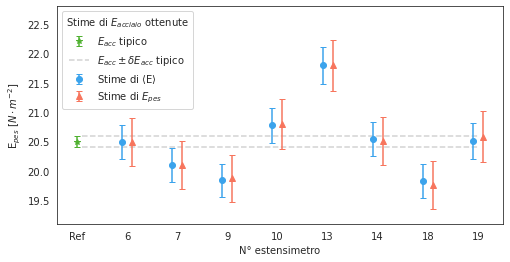

In [626]:
def plot_confr1e2():
    def p0():
        plt.errorbar([0], [acc_E], [acc_E_sig], fmt='*', capsize=3, label='$E_{acc}$ tipico', color=palette24[8])
    def p1(dss):
        Y = list(dss.mE.to_numpy())
        Yerr = list(dss.mE_sig.to_numpy())
        X = np.array(list(range(len(Y)))) + 1 - .1

        plt.errorbar(X, Y, Yerr, fmt='o', capsize=3, label='Stime di $\\langle$E$\\rangle$', color=palette24[16])
        # plt.errorbar(X[0], Y[0], Yerr[0], fmt='o', capsize=3, label='$E_{acc}$ tipico', color=palette24[8])
    def p2(dss):
        Y = list(dss.Ep.to_numpy())
        Yerr = list(dss.Ep_sig.to_numpy())
        X = np.array(list(range(len(Y)))) + 1 + .1

        plt.errorbar(X, Y, Yerr, fmt='^', capsize=3, label='Stime di $E_{pes}$', color=palette24[1])
        # plt.errorbar(X[0], Y[0], Yerr[0], fmt='o', capsize=3, label='$E_{acc}$ tipico', color=palette24[8])

    # COMMON
    sns.set_style('white')
    plot_id = graph_base_name + '00_confr_acc_Epes'
    # plt.figure(figsize=graph_default_size)
    plt.figure(figsize=(8,4))
    
    acc_E = 20.5 * 10 ** 10
    acc_E_sig = .1 * 10 ** 10
    
    acc_E_max = acc_E + acc_E_sig
    acc_E_min = acc_E - acc_E_sig
    
    acc_ds = ds.where(ds.mat == 'acciaio', drop=True)

    # 

    Y = [acc_E] + list(acc_ds.Ep.to_numpy())
    X = list(range(len(Y)))
    Yn = list(acc_ds.n.to_numpy())
    Xlab = ['Ref'] + [str(x) for x in Yn]

    plt.plot([0.1, X[-1]], [acc_E_max, acc_E_max], '--', color='lightgrey', label='$E_{acc} \pm \delta E_{acc}$ tipico')
    plt.plot([0.1, X[-1]], [acc_E_min, acc_E_min], '--', color='lightgrey')
    
    #

    p0()
    p1(acc_ds)
    p2(acc_ds)

    #

    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(x/10**10, ',')))
    
    plt.xticks(X, Xlab)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1,0,2,3]
    plt.legend([handles[i] for i in order],[labels[i] for i in order], loc='upper left', title='Stime di $E_{acciaio}$ ottenute')
    
    plt.xlabel('N° estensimetro')
    plt.ylabel('E$_{pes}$ $[N \cdot m^{-2}]$')
    
    plt.ylim(191 * 1000000000, 228 * 1000000000)

    # Save
    plt.savefig(plot_id, dpi=graph_default_dpi)

plot_confr1e2()

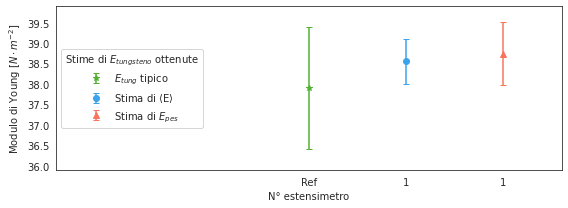

In [637]:
def plot_confr3():
    sns.set_style('white')
    plot_id = graph_base_name + '00_confr_tung'
    # plt.figure(figsize=graph_default_size)
    plt.figure(figsize=(8,3))
    
    tung_E = 37.9 * 10 ** 10
    tung_E_sig = 1.5 * 10 ** 10
    
    tung_E_max = tung_E + tung_E_sig
    tung_E_min = tung_E - tung_E_sig
    
    tung_ds = ds.where(ds.mat == 'tungsteno', drop=True)
    
    Y = [tung_E] + list(tung_ds.mE.to_numpy()) + list(tung_ds.Ep.to_numpy())
    Yerr = [tung_E_sig] + list(tung_ds.mE_sig.to_numpy()) + list(tung_ds.Ep_sig.to_numpy())
    Yn = tung_ds.n.to_numpy().tolist() + tung_ds.n.to_numpy().tolist()
    
    X = list(range(len(Y)))
    Xlab = ['Ref'] + [str(x) for x in Yn]
    # Xlab[2] = Xlab[2] + ' pes'
    
    # plt.plot([.05, X[-1]], [tung_E_max, tung_E_max], '--', color='lightgrey', label='$E_{tung} \pm \delta E_{tung}$ tipico')
    # plt.plot([.05, X[-1]], [tung_E_min, tung_E_min], '--', color='lightgrey')
    
    plt.errorbar(X[1], Y[1], Yerr[1], fmt='o', capsize=3, label='Stima di $\\langle$E$\\rangle$', color=palette24[16])
    plt.errorbar(X[2], Y[2], Yerr[2], fmt='^', capsize=3, label='Stima di $E_{pes}$', color=palette24[1])
    plt.errorbar(X[0], Y[0], Yerr[0], fmt='*', capsize=3, label='$E_{tung}$ tipico', color=palette24[8])
    
    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(x/10**10, ',')))
    
    plt.xticks(X, Xlab)
    plt.xlim(-2.6,2.6)
    plt.ylim(35.9 *10**10, 39.9 *10**10)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2,0,1]
    plt.legend([handles[i] for i in order],[labels[i] for i in order], loc='center left', title='Stime di $E_{tungsteno}$ ottenute')
    
    plt.xlabel('N° estensimetro')
    plt.ylabel('Modulo di Young $[N \cdot m^{-2}]$')
    
    plt.tight_layout()
    
    # Save
    plt.savefig(plot_id, dpi=graph_default_dpi)

plot_confr3()

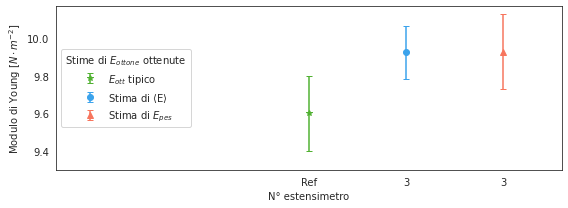

In [638]:
def plot_confr4():
    sns.set_style('white')
    plot_id = graph_base_name + '00_confr_ott'
    # plt.figure(figsize=graph_default_size)
    plt.figure(figsize=(8,3))
    
    ott_E = 9.6 * 10 ** 10
    ott_E_sig = .2 * 10 ** 10
    
    ott_E_max = ott_E + ott_E_sig
    ott_E_min = ott_E - ott_E_sig
    
    ott_ds = ds.where(ds.mat == 'ottone', drop=True)
    
    Y = [ott_E] + ott_ds.mE.to_numpy().tolist() + ott_ds.Ep.to_numpy().tolist()
    Yerr = [ott_E_sig] + ott_ds.mE_sig.to_numpy().tolist() + ott_ds.Ep_sig.to_numpy().tolist()
    Yn = ott_ds.n.to_numpy().tolist() + ott_ds.n.to_numpy().tolist()
    
    X = list(range(len(Y)))
    Xlab = ['Ref'] + [str(x) for x in Yn]
    # Xlab[2] = Xlab[2] + ' pes'
    
    # plt.plot([.05, X[-1]], [ott_E_max, ott_E_max], '--', color='lightgrey', label='$E_{ott} \pm \delta E_{ott}$ tipico')
    # plt.plot([.05, X[-1]], [ott_E_min, ott_E_min], '--', color='lightgrey')
    
    plt.errorbar(X[1], Y[1], Yerr[1], fmt='o', capsize=3, label='Stima di $\\langle$E$\\rangle$', color=palette24[16])
    plt.errorbar(X[2], Y[2], Yerr[2], fmt='^', capsize=3, label='Stima di $E_{pes}$', color=palette24[1])
    plt.errorbar(X[0], Y[0], Yerr[0], fmt='*', capsize=3, label='$E_{ott}$ tipico', color=palette24[8])
    
    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(x/10**10, ',')))
    
    plt.xticks(X, Xlab)
    plt.xlim(-2.6,2.6)
    plt.ylim(9.3 *10**10, 10.17 *10**10)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2,0,1]
    plt.legend([handles[i] for i in order],[labels[i] for i in order], loc='center left', title='Stime di $E_{ottone}$ ottenute')
    
    plt.xlabel('N° estensimetro')
    plt.ylabel('Modulo di Young $[N \cdot m^{-2}]$')
    
    plt.tight_layout()
    
    # Save
    plt.savefig(plot_id, dpi=graph_default_dpi)

plot_confr4()

#### Export

In [29]:
ds

<xarray.Dataset>
Dimensions:  (n: 10, F: 11, dir: 2, deg: 2)
Coordinates:
  * n        (n) int64 1 3 6 7 9 10 13 14 18 19
  * F        (F) float64 0.0 3.92 7.84 11.76 15.68 ... 27.44 31.36 35.28 39.2
  * dir      (dir) <U7 'andata' 'ritorno'
  * deg      (deg) int64 1 0
Data variables: (12/19)
    mat      (n) <U9 'tungsteno' 'ottone' 'acciaio' ... 'acciaio' 'acciaio'
    D        (n) float64 0.00025 0.0005 0.000305 ... 0.000279 0.000279 0.000279
    D_sig    (n) float64 2.5e-06 5e-06 3.05e-06 ... 2.79e-06 2.79e-06 2.79e-06
    L        (n) float64 1.0 1.0 0.95 0.95 0.95 0.95 0.9 0.8 0.4 0.3
    L_sig    (n) float64 0.002 0.002 0.002 0.002 ... 0.002 0.002 0.002 0.002
    F_sig    (F) float64 1.307 1.307 1.307 1.307 ... 1.307 1.307 1.307 1.307
    ...       ...
    mE       (n) float64 3.856e+11 9.926e+10 2.049e+11 ... 1.983e+11 2.052e+11
    mE_sig   (n) float64 5.48e+09 1.411e+09 2.914e+09 ... 2.89e+09 3.058e+09
    mK       (n) float64 5.261e-05 5.133e-05 6.347e-05 ... 3.312e-05 2.386e-05
    mK_sig   (n) float64 9e-10 1.094e-10 2.28e-10 ... 2.27e-10 4.98e-10 1.53e-10
    Ep       (n) float64 3.874e+11 9.928e+10 2.05e+11 ... 1.977e+11 2.058e+11
    Ep_sig   (n) float64 7.787e+09 1.995e+09 4.122e+09 ... 4.075e+09 4.338e+09

In [30]:
ds[['K', 'K_sig']].to_dataframe().to_excel('dump_k.xlsx')

In [31]:
ds[['mK', 'mK_sig']].to_dataframe().to_excel('dump_mk.xlsx')

In [32]:
ds[['E', 'E_sig']].to_dataframe().to_excel('dump_e.xlsx')

In [33]:
ds[['mE', 'mE_sig']].to_dataframe().to_excel('dump_me.xlsx')

In [34]:
ds[['Ep', 'Ep_sig']].to_dataframe().to_excel('dump_ep.xlsx')